In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)
sys.path.append(os.path.join(parent_folder_path, 'simulator'))
sys.path.append(os.path.join(parent_folder_path, 'equities/data_processing'))

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np
import pandas as pd
import random
from typing import List, Tuple, Union
from copy import deepcopy
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from contextlib import nullcontext
import torch

from simulator.core import Message
from simulator.core.utils import str_to_ns, fmt_ts
from simulator.markets.order_book import OrderBook
from simulator.markets.orders import LimitOrder, Side, MarketOrder
from equities.data_processing import itch_preproc
from equities.data_processing import itch_encoding
from equities.model import GPTConfig, GPT
from equities.data_processing import itch_encoding

/tmp/ipykernel_1187224/286662489.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# INIT PARAMS
# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = parent_folder_path + '/out' # ignored if init_from is not 'resume'
# dataset = '12302019.NASDAQ_ITCH50_AAPL_message_proc.npy' # dataset to use for initial prompt
# start = "\n" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_context_msgs = 100 # 400 # number of messages from dataset to use as context
# num_samples = 10 # number of samples to draw
num_samples = 1 # number of samples to draw (think of like monte carlo paths)
# max_new_tokens = 500 # number of tokens generated in each sample
max_new_tokens = 1 # number of tokens generated in each sample (think of like time steps)
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 42
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('equities/configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


In [4]:
TIME = 0
WORLD_AGENT_ID = 1

class FakeExchangeAgent:
    def __init__(self):
        self.messages = []
        self.current_time = TIME
        self.mkt_open = TIME
        self.book_logging = None
        self.stream_history = 10

    def reset(self):
        self.messages = []

    def send_message(self, recipient_id: int, message: Message, _: int = 0):
        self.messages.append((recipient_id, message))

    def logEvent(self, *args, **kwargs):
        pass

In [5]:
# define load paths
raw_itch_load_path = parent_folder_path + '/dataset/raw/ITCH/'
processed_dataset = '03272019.NASDAQ_ITCH50_AAPL_message_proc.npy'
proc_data_dir = os.path.join('dataset/proc/ITCH/full_view/', processed_dataset)
proc_data_dir = parent_folder_path + '/' + proc_data_dir
symbols_load_path = parent_folder_path + '/dataset/symbols/'
symbols_file = sorted(glob(symbols_load_path + '*sp500*.txt'))[0]

# locate raw ITCH data
itch_message_files = sorted(glob(raw_itch_load_path + '*message*.csv'))
itch_book_files = sorted(glob(raw_itch_load_path + '*book*.csv'))
print('found', len(itch_message_files), 'ITCH message files')
print('found', len(itch_book_files), 'ITCH book files')

# create reverse ticker symbol mapping (key is index, value is ticker)
tickers = {}
with open(symbols_file) as f:
    idx = 0
    for line in f:
        idx += 1
        # tickers[line.strip()] = idx
        tickers[idx] = line.strip()

# load raw ITCH data (book)
symbols = []
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    if '03272019' not in m_f:
        continue
    print(m_f)
    # print(b_f)
    
    first_message = (itch_preproc.load_message_df(m_f)).iloc[0]
    print(first_message)

    # itch_book = pd.read_csv(
    #     b_f,
    #     # index_col=False,
    #     # header=None
    # )
    # assert len(itch_messages) == len(itch_book)

    # # remove disallowed order types
    # allowed_events=['A','E','C','D','R']
    # itch_messages = itch_messages.loc[itch_messages.type.isin(allowed_events)]
    # # make sure book is same length as messages
    # itch_book = itch_book.loc[itch_messages.index]

    # print("ITCH messages shape:", itch_messages.shape)
    # print("ITCH book shape:", itch_book.shape)

    # # remove time field from ITCH book data
    # itch_book = itch_book.drop(columns=['time'])

    # symbol to store in list and use to create OB objects in loop later
    symbol = m_f.rsplit('/', maxsplit=1)[-1][:-12].rsplit('_', maxsplit=1)[-1]
    print("Adding symbol:", symbol)
    symbols.append(symbol)

# load processed ITCH data (messages)
# proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:num_context_msgs])
# proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(12749 + num_context_msgs)])\
proc_messages = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(15700 + num_context_msgs)])
# assert len(itch_book) == len(proc_messages) + 1 # off by 1 bc of first message
print("proc_messages.shape:", proc_messages.shape)
print("proc_messages:", proc_messages)
print([ "ticker", "order_id",
        "event_type", "direction", "price_abs", "price", "fill_size", "remain_size",
        "delta_t_s", "delta_t_ns", "time_s", "time_ns", "old_id",
        "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"])

found 8 ITCH message files
found 8 ITCH book files


0it [00:00, ?it/s]

/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/03272019.NASDAQ_ITCH50_AAPL_message.csv


8it [00:00, 14.25it/s]

time        14400006432545
type                     A
id                   13301
side                     1
size                  18.0
price               207.85
cancSize               NaN
execSize               NaN
oldId                  NaN
oldSize                NaN
oldPrice               NaN
mpid                   NaN
Name: 0, dtype: object
Adding symbol: AAPL
proc_messages.shape: (15800, 18)
proc_messages: [[       40     15969         1 ...     -9999     -9999     -9999]
 [       40     20677         1 ...     -9999     -9999     -9999]
 [       40     22061         1 ...     -9999     -9999     -9999]
 ...
 [       40  10784589         1 ...     -9999     -9999     -9999]
 [       40  10784485         4 ...     34224 458374665     -9999]
 [       40  10784597         1 ...     -9999     -9999     -9999]]
['ticker', 'order_id', 'event_type', 'direction', 'price_abs', 'price', 'fill_size', 'remain_size', 'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns', 'old_id', 'price_ref', 'fill_

In [6]:
# init new book under nasdaq agent
nasdaq_agent = FakeExchangeAgent()

# create a dictionary of order books based on each symbol in symbols
print("Creating order books for symbols:", symbols)
order_books = {}
for symbol in symbols:
    order_books[symbol] = OrderBook(nasdaq_agent, symbol)

# empty book
assert order_books[tickers[proc_messages[0][0]]].bids == order_books[tickers[proc_messages[0][0]]].asks == []

Creating order books for symbols: ['AAPL']


In [7]:
# first message is missing in proc_messages, so we'll use the raw message file to start the book
print(first_message)

# insert bid order
bid_order = LimitOrder(
    order_id=first_message['id'],
    agent_id=1, # world agent, leave alone for now
    time_placed=first_message['time'],
    symbol=symbols[0],
    quantity=int(first_message['size']),
    side=Side.BID if first_message['side'] == 0 else Side.ASK,
    limit_price=int(first_message['price']*100),
)
order_books[symbols[0]].handle_limit_order(bid_order)

print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
nasdaq_agent.messages

time        14400006432545
type                     A
id                   13301
side                     1
size                  18.0
price               207.85
cancSize               NaN
execSize               NaN
oldId                  NaN
oldSize                NaN
oldPrice               NaN
mpid                   NaN
Name: 0, dtype: object
L3 bid data: []
L3 ask data: [(20785, [18])]


[(1,
  OrderAcceptedMsg(message_id=1, order=(Agent 1 @ 1970-01-01 04:00:00) : ASK 18 AAPL @ $207.85))]

In [8]:
# INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# init variables to keep track of previous time, price, etc.
prev_time = first_message['time']
prev_price = int(first_message['price']*100)
L1 = [] # list to store L1 data for plotting
last_prices = [] # list to store last prices for plotting

# iterate through messages and update order books
for msg in proc_messages:
    # print(msg)
    symbol = tickers[msg[0]]
    # print("Symbol:", symbol)
    order_id = msg[1]
    # print("Order ID:", order_id)
    event_type = msg[2]
    # print("Event Type:", event_type)
    price = msg[4]
    # print("Price:", price)

    # verify time correctness
    assert prev_time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11]
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)

    # handle order based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(order)
    elif event_type == 2:
        # EXECUTE ORDER
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order_size = msg[14]
        ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define original order
        original_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=ref_order_price,
        )
        # define modified order
        # modified_price = msg[4]
        modified_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=ref_order_time,
            symbol=symbol,
            quantity=ref_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].modify_order(original_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        order = MarketOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=fill_size,
                # quantity=msg[14], # total size of order when placed
                side=direction,
                limit_price=price,
            )
            order_books[symbol].cancel_order(order)
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            order = LimitOrder(
                order_id=order_id,
                agent_id=1, # world agent, leave alone for now
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=ref_order_size,
                side=direction,
                limit_price=price,
            )
            order_books[symbol].partial_cancel_order(order, cancel_size)
    elif event_type == 5:
        # REPLACE ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        old_order_id = msg[12]
        old_order_time = (msg[15] * 1000000000) + msg[16]
        old_order_size = msg[14]
        old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # define old order
        old_order = LimitOrder(
            order_id=old_order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=old_order_time,
            symbol=symbol,
            quantity=old_order_size,
            side=direction,
            limit_price=old_order_price,
        )
        new_order_size = msg[6]
        # define new order
        new_order = LimitOrder(
            order_id=order_id,
            agent_id=1, # world agent, leave alone for now
            time_placed=time,
            symbol=symbol,
            quantity=new_order_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
    else:
        raise NotImplementedError("Event type not implemented")

    # update previous time and price
    prev_time = time
    prev_price = price

    # update plotting variables
    L1.append((time, order_books[symbol].get_l1_bid_data(), order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices.append((time, price))
    
# print end result
print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
nasdaq_agent.messages

L3 bid data: [(18879, [100]), (18878, [300]), (18877, [100, 400]), (18876, [100, 400]), (18875, [100, 500]), (18874, [500]), (18873, [100]), (18871, [100]), (18866, [100]), (18860, [200]), (18845, [500]), (18842, [740]), (18841, [700]), (18837, [1]), (18833, [50]), (18831, [200, 100]), (18829, [60]), (18827, [1]), (18825, [10, 5, 4, 2, 5, 10, 500]), (18824, [400, 30, 10]), (18823, [100, 8]), (18821, [400]), (18820, [15, 2, 23, 75, 3, 1, 1]), (18819, [100]), (18818, [1, 5]), (18817, [15, 41, 1, 10]), (18815, [1, 25]), (18813, [2]), (18811, [50, 1]), (18810, [500, 3, 1, 1, 6, 200]), (18808, [100, 3]), (18806, [25]), (18805, [200, 10]), (18804, [100]), (18802, [300, 10, 8]), (18800, [4, 1, 1, 1, 1, 1, 1, 50, 100, 100, 200, 100, 20, 100, 10, 10, 1, 3, 12, 1, 1, 1, 24, 80, 50, 100, 9, 1, 5, 1, 10, 1, 100, 5, 55, 4, 2, 1, 10, 25, 10, 27, 5, 5, 98, 142, 1000, 95, 100, 60, 60, 100, 10, 48, 6, 1000, 40, 16, 10, 4, 5, 1, 1, 1, 8, 100, 10, 3, 1, 65, 60, 6, 50, 1, 57, 1, 200, 100, 30, 6, 10, 9999,

[(1,
  OrderAcceptedMsg(message_id=1, order=(Agent 1 @ 1970-01-01 04:00:00) : ASK 18 AAPL @ $207.85)),
 (1,
  OrderAcceptedMsg(message_id=2, order=(Agent 1 @ 1970-01-01 04:00:00) : BID 100 AAPL @ $129.33)),
 (1,
  OrderAcceptedMsg(message_id=3, order=(Agent 1 @ 1970-01-01 04:00:00) : BID 1 AAPL @ $114.94)),
 (1,
  OrderAcceptedMsg(message_id=4, order=(Agent 1 @ 1970-01-01 04:00:00) : BID 1 AAPL @ $98.39)),
 (1,
  OrderAcceptedMsg(message_id=5, order=(Agent 1 @ 1970-01-01 04:00:03) : ASK 300 AAPL @ $192.70)),
 (1,
  OrderAcceptedMsg(message_id=6, order=(Agent 1 @ 1970-01-01 04:00:03) : ASK 85 AAPL @ $214.90)),
 (1,
  OrderAcceptedMsg(message_id=7, order=(Agent 1 @ 1970-01-01 04:00:03) : ASK 150 AAPL @ $225.00)),
 (1,
  OrderAcceptedMsg(message_id=8, order=(Agent 1 @ 1970-01-01 04:00:03) : ASK 5 AAPL @ $225.00)),
 (1,
  OrderAcceptedMsg(message_id=9, order=(Agent 1 @ 1970-01-01 04:00:05) : BID 25 AAPL @ $185.73)),
 (1,
  OrderAcceptedMsg(message_id=10, order=(Agent 1 @ 1970-01-01 04:00:1

len(L1): 15800


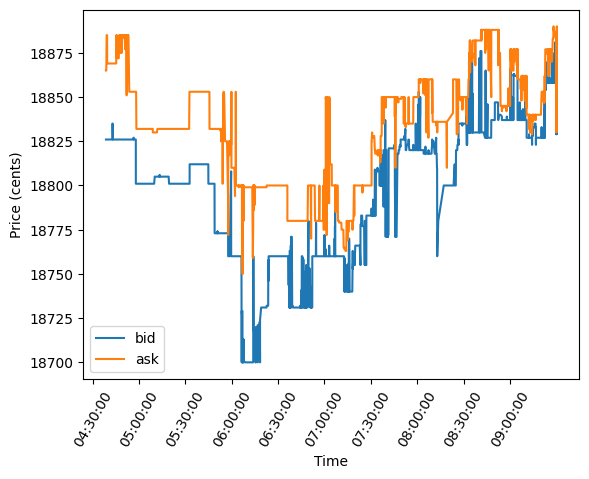

In [9]:
print("len(L1):", len(L1))

# plot L1 data
times = [L1[i][0] for i in range(len(L1))]
bids = [L1[i][1][0] for i in range(len(L1))]
asks = [L1[i][2][0] for i in range(len(L1))]
# plt.plot(times, bids, label='bid')
# plt.plot(times, asks, label='ask')

# plot last 14000 time steps
plt.plot(times[-14000:], bids[-14000:], label='bid')
plt.plot(times[-14000:], asks[-14000:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    str_to_ns("09:30:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

len(last_prices): 580


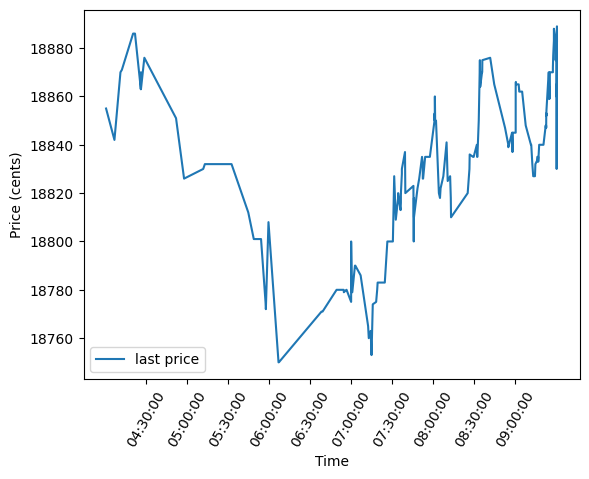

In [10]:
print("len(last_prices):", len(last_prices))

# plot last prices
times = [last_prices[i][0] for i in range(len(last_prices))]
prices = [last_prices[i][1] for i in range(len(last_prices))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
# plt.show()

time_mesh = np.arange(
    str_to_ns("04:30:00"),
    str_to_ns("09:30:00"),
    1e9*60*30 # last number is minutes increment (every 30 minutes in this case)
)
_=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

# TODO: put in *-minute buckets plot series

In [11]:
# INIT MODEL
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)

model.eval()
model.to(device)

number of parameters: 94.57M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(12515, 768)
    (wpe): Embedding(10367, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=12515, bias=False)
)

In [12]:
# encode the context data
vocab = itch_encoding.Vocab()
# take the last 'num_context_msgs' messages as context
X_raw = proc_messages[-num_context_msgs:]
print("X_raw.shape:", X_raw.shape)
print("X_raw:", X_raw)
print("X_raw (last msg):", X_raw[-1])
X = itch_encoding.encode_msgs(X_raw, vocab.ENCODING)
print("X.shape:", X.shape)
print("X:", X)
# ex. decode the context data (will be missing order id, price_abs, old_id, and old_price_abs)
print("decoded X (last msg):", itch_encoding.decode_msg(X[-1], vocab.ENCODING))
time = itch_encoding.decode_msg(X[-1], vocab.ENCODING)[10] * 1000000000 + itch_encoding.decode_msg(X[-1], vocab.ENCODING)[11]
print("current simulation time:", time)
gen_start_time = time # for computing simulation time elapsed in generation

encoded_tok_len = X.shape[1]
print("encoded_tok_len:", encoded_tok_len)

# prepare context tensor
x = (torch.tensor(X.reshape(-1), dtype=torch.long, device=device)[None, ...])
print("x.shape:", x.shape)
print("x:", x)

X_raw.shape: (100, 18)
X_raw: [[       40  10229733         4 ...     34204 724701431     -9999]
 [       40  10229729         4 ...     34204 724582150     -9999]
 [       40  10776961         1 ...     -9999     -9999     -9999]
 ...
 [       40  10784589         1 ...     -9999     -9999     -9999]
 [       40  10784485         4 ...     34224 458374665     -9999]
 [       40  10784597         1 ...     -9999     -9999     -9999]]
X_raw (last msg): [       40  10784597         1         1     18885         5       400
     -9999         0    458256     34224 465960326     -9999     -9999
     -9999     -9999     -9999     -9999]
X.shape: (100, 24)
X: [[12051  1006 12011 ...   727   704   434]
 [12051  1006 12011 ...   727   585   153]
 [12051  1003 12011 ...     2     2     2]
 ...
 [12051  1003 12011 ...     2     2     2]
 [12051  1006 12011 ...   461   377   668]
 [12051  1003 12011 ...     2     2     2]]
decoded X (last msg): [       40     -9999         1         1     -9999  

In [13]:
# # run generation
# with torch.no_grad():
#     with ctx:
#         for k in range(num_samples):
#             # y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
#             y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=top_k)
#             # print(decode(y[0].tolist()))
#             # print("last generated msg:", y[0][-1].tolist())
#             # print(y[0].tolist())
#             print('---------------')
#         # print("new sequence", y[0].tolist())
#         print("new sequence", y)

In [14]:
# # print the last message in the generated sequence
# print("last generated msg:", y[0][-24:].tolist())

# # print(y[0].tolist())
# print("y:", y)

# # decode the generated sequence
# # print("decoded y:", itch_encoding.decode_msg(y[0][-24:].tolist(), vocab.ENCODING))
# # print("decoded msg:", itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING))
# decoded_msg = itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING)
# print("decoded msg:", decoded_msg)
# print([ "ticker", "NA_VAL",
#         "event_type", "direction", "NA_VAL", "price", "fill_size", "remain_size",
#         "delta_t_s", "delta_t_ns", "time_s", "time_ns",
#         "NA_VAL", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "NA_VAL"])

# # X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:num_context_msgs+max_new_tokens])
# # X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(12749+num_context_msgs)+max_new_tokens])
# X_true = np.array(np.load(proc_data_dir, mmap_mode='r')[0:(15700+num_context_msgs)+max_new_tokens])
# print("X_true:", X_true)

# print("true last msg:", X_true[-1])

In [15]:
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# print("bid_price:", bid_price)
# print("ask_price:", ask_price)
# mid_price = ((bid_price + ask_price) / 2) // 1
# print("mid_price:", mid_price)

# print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
# print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())

In [16]:
# print("decoded msg:", decoded_msg)
# print("predicted symbol:", tickers[decoded_msg[0]])
# print("predicted event type:", decoded_msg[2])
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# mid_price = ((bid_price + ask_price) / 2) // 1
# new_price = int(mid_price) + decoded_msg[5]
# print("predicted price:", new_price)
# print("predicted fill size:", decoded_msg[6])
# print("predicted remain size:", decoded_msg[7])
# print("predicted delta time (s, ns):", decoded_msg[8], decoded_msg[9])
# print("current simulation time:", time)
# new_time = time + (decoded_msg[8]*1000000000) + decoded_msg[9]
# print("predicted time:", new_time) # time used to place order in sim
# print("(sim ignored) predicted time:", (decoded_msg[10] * 1000000000) + decoded_msg[11]) # ignored in sim (time_s, time_ns)
# print("Passes predicted time consistency:" , time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11])
# print("predicted price ref:", decoded_msg[13])
# print("predicted fill size ref:", decoded_msg[14])
# print("predicted time ref:", (decoded_msg[15] * 1000000000) + decoded_msg[16])

# decoded_msg

In [17]:
def find_matching_order(order_book: OrderBook, direction: Side, price: int, fill_size: int, ref_order_time: int) -> LimitOrder:    
    # Error correction: find matching order in order book or re-run timestep if None
    book = order_book.bids if direction.is_bid() else order_book.asks

    for i, price_level in enumerate(book):
        if not price_level.price == price:
            continue

        # print("price match found at level:", i)
        # print("orders at this price level:", price_level.visible_orders)

        # compile candidate orders
        candidate_orders = []
        for order in price_level.visible_orders:
            # print("order:", order[0])
            candidate_orders.append(order[0]) if order[0].agent_id == WORLD_AGENT_ID else None

        # find matching order
        # print("candidate orders:", candidate_orders)
        candidiate_size_only = []
        candidiate_time_only = []
        for order in candidate_orders:
            if order.quantity == fill_size and order.time_placed == ref_order_time:
                # print("matching order (size & time) found:", order)
                return deepcopy(order)
            elif order.quantity == fill_size and order.time_placed != ref_order_time:
                # print("matching order (size only) found:", order)
                candidiate_size_only.append(order)
            elif order.quantity != fill_size and order.time_placed == ref_order_time:
                # print("matching order (time only) found:", order)
                candidiate_time_only.append(order)
            # else:
                # print("no matching order found")

        if len(candidiate_size_only) >= 1:
            # print("return matching order (size only):", candidiate_size_only[0])
            return deepcopy(candidiate_size_only[0])
        elif len(candidiate_time_only) >= 1:
            # print("return matching order (time only):", candidiate_time_only[0])
            return deepcopy(candidiate_time_only[0])
        elif len(candidate_orders) >= 1:
            # print("no matching order found. Return initial volume at price level:", candidate_orders[0])
            return deepcopy(candidate_orders[0])

    # throw error if no match found
    # raise ValueError("No matching order found in order book")
    return None

In [18]:
def process_message(
        symbol: str,
        price: int,
        time: int,
        event_type: int,
        msg: np.ndarray,
        order_books: dict,
        agent_id: int = 1, # world agent by default
# ) -> Union[LimitOrder, MarketOrder, Tuple[LimitOrder, LimitOrder], None]:
):
    """Handles ITCH message processing and order book updates.

    Arguments:
        price (int): Price of order.
        time (int): Time of order.
        event_type (int): Type of event.
        msg (np.ndarray): ITCH message.
        order_book (OrderBook): Order book object.
    """

    # handle message based on event type
    if event_type == 1:
        # ADD LIMIT ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].handle_limit_order(new_order)
        ref_order = None
    elif event_type == 2:
        # raise NotImplementedError("Event type 2 not implemented")
        # EXECUTE ORDER
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        new_order = MarketOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        )
        order_books[symbol].handle_market_order(new_order)
        ref_order = None
    elif event_type == 3:
        # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
        raise NotImplementedError("Event type 3 not implemented")
        # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
        # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
        # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

        # modfify the matched limit order
        direction = Side.BID if msg[3] == 0 else Side.ASK
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order_size = msg[14]
        ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
        # # define original order
        # original_order = LimitOrder(
        #     order_id=order_id,
        #     agent_id=agent_id,
        #     time_placed=ref_order_time,
        #     symbol=symbol,
        #     quantity=ref_order_size,
        #     side=direction,
        #     limit_price=ref_order_price,
        # )
        # # define modified order
        # # modified_price = msg[4]
        # modified_order = LimitOrder(
        #     order_id=order_id,
        #     agent_id=agent_id,
        #     time_placed=ref_order_time,
        #     symbol=symbol,
        #     quantity=ref_order_size,
        #     side=direction,
        #     limit_price=price,
        # )
        # order_books[symbol].modify_order(original_order, modified_order)
        # execute the modified order
        fill_size = msg[6]
        # print("Fill Size:", fill_size)
        direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
        # print("Direction:", direction)
        # order = MarketOrder(
        #     order_id=order_id,
        #     agent_id=agent_id,
        #     time_placed=time,
        #     symbol=symbol,
        #     quantity=fill_size,
        #     side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
        # )
        # order_books[symbol].handle_market_order(order)
    elif event_type == 4:
        # CANCEL ORDER
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        if msg[7] == 0:
            # FULL DELETION
            fill_size = msg[6]
            # print("Cancel Size:", fill_size)
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, fill_size, ref_order_time)
            if ref_order is None:
                return None, None
            # order = LimitOrder(
            #     order_id=order_id,
            #     agent_id=agent_id,
            #     time_placed=ref_order_time,
            #     symbol=symbol,
            #     quantity=fill_size,
            #     # quantity=msg[14], # total size of order when placed
            #     side=direction,
            #     limit_price=price,
            # )
            order_books[symbol].cancel_order(ref_order)
            new_order = None
        else:
            # PARTIAL CANCELLATION
            cancel_size = msg[6]
            # print("Partial Cancel Size:", cancel_size)
            ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
            # This is a reference order type, so we must undergo the error correction procedure
            ref_order = find_matching_order(order_books[symbol], direction, price, ref_order_size, ref_order_time)
            if ref_order is None:
                return None, None
            if ref_order.quantity is not ref_order_size:
                # preserve intent of generated partial cancel order
                cancel_ratio = cancel_size / ref_order_size
                cancel_size = int(ref_order.quantity * cancel_ratio)
            # order = LimitOrder(
            #     order_id=order_id,
            #     agent_id=agent_id,
            #     time_placed=ref_order_time,
            #     symbol=symbol,
            #     quantity=ref_order_size,
            #     side=direction,
            #     limit_price=price,
            # )
            order_books[symbol].partial_cancel_order(ref_order, cancel_size)
            # make dummy order to track new cancel_size
            new_order = LimitOrder(
                order_id=-1,
                agent_id=agent_id,
                time_placed=ref_order_time,
                symbol=symbol,
                quantity=cancel_size, # partial cancel size
                side=direction,
                limit_price=0,
            )
    elif event_type == 5:
        # REPLACE ORDER
        # raise NotImplementedError("Event type 5 not implemented")
        direction = Side.BID if msg[3] == 0 else Side.ASK
        # print("Direction:", direction)
        # This is a reference order type, so we must undergo the error correction procedure
        # get reference order details
        bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
        mid_price = ((bid_price + ask_price) / 2) // 1
        ref_price = int(mid_price) + msg[13]
        ref_size = msg[14]
        ref_order_time = (msg[15] * 1000000000) + msg[16]
        ref_order = find_matching_order(order_books[symbol], direction, ref_price, ref_size, ref_order_time)
        if ref_order is None:
            return None, None

        # old_order_id = msg[12]
        # old_order_time = (msg[15] * 1000000000) + msg[16]
        # old_order_size = msg[14]
        # old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])

        # # define old order
        # old_order = LimitOrder(
        #     order_id=old_order_id,
        #     agent_id=agent_id,
        #     time_placed=old_order_time,
        #     symbol=symbol,
        #     quantity=old_order_size,
        #     side=direction,
        #     limit_price=old_order_price,
        # )
        # define new order
        fill_size = msg[6]
        new_order = LimitOrder(
            agent_id=agent_id,
            time_placed=time,
            symbol=symbol,
            quantity=fill_size,
            side=direction,
            limit_price=price,
        )
        order_books[symbol].replace_order(agent_id, old_order, new_order)
        # return old_order, new_order
    else:
        raise NotImplementedError(f"Event type {event_type} not implemented")
    
    # return order object for next message encoding step
    # return order
    return new_order, ref_order

In [19]:
# # INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# # init variables to keep track of previous time, price, etc.
# prev_time = time
# prev_price = price
# msg = decoded_msg

# print(msg)
# symbol = tickers[msg[0]]
# print("Symbol:", symbol)
# # order_id = msg[1]
# # print("Order ID:", order_id)
# event_type = msg[2]
# print("Event Type:", event_type)
# # get mid-price of symbol
# bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
# mid_price = ((bid_price + ask_price) / 2) // 1
# price = int(mid_price) + decoded_msg[5]
# print("Price:", price)
# time = prev_time + (msg[8]*1000000000) + msg[9]
# print("Time:", time)

# order = process_message(symbol, price, time, event_type, msg, order_books, agent_id=WORLD_AGENT_ID)

# # # handle order based on event type
# # if event_type == 1:
# #     # ADD LIMIT ORDER
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     # order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].handle_limit_order(order)
# # elif event_type == 2:
# #     raise NotImplementedError("Event type 2 not implemented")
# #     # EXECUTE ORDER
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
# #     print("Direction:", direction)
# #     # order = MarketOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
# #     # )
# #     # order_books[symbol].handle_market_order(order)
# # elif event_type == 3:
# #     # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
# #     raise NotImplementedError("Event type 3 not implemented")
# #     # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
# #     # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
# #     # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

# #     # modfify the matched limit order
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     ref_order_time = (msg[15] * 1000000000) + msg[16]
# #     ref_order_size = msg[14]
# #     ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
# #     # # define original order
# #     # original_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=ref_order_time,
# #     #     symbol=symbol,
# #     #     quantity=ref_order_size,
# #     #     side=direction,
# #     #     limit_price=ref_order_price,
# #     # )
# #     # # define modified order
# #     # # modified_price = msg[4]
# #     # modified_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=ref_order_time,
# #     #     symbol=symbol,
# #     #     quantity=ref_order_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].modify_order(original_order, modified_order)
# #     # execute the modified order
# #     fill_size = msg[6]
# #     print("Fill Size:", fill_size)
# #     direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
# #     print("Direction:", direction)
# #     # order = MarketOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=fill_size,
# #     #     side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
# #     # )
# #     # order_books[symbol].handle_market_order(order)
# # elif event_type == 4:
# #     # CANCEL ORDER
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     ref_order_time = (msg[15] * 1000000000) + msg[16]
# #     if msg[7] == 0:
# #         # FULL DELETION
# #         fill_size = msg[6]
# #         print("Cancel Size:", fill_size)
# #         # This is a reference order type, so we must undergo the error correction procedure
# #         order = find_matching_order(order_books[symbol], direction, price, fill_size, ref_order_time)
# #         # order = LimitOrder(
# #         #     order_id=order_id,
# #         #     agent_id=1, # world agent, leave alone for now
# #         #     time_placed=ref_order_time,
# #         #     symbol=symbol,
# #         #     quantity=fill_size,
# #         #     # quantity=msg[14], # total size of order when placed
# #         #     side=direction,
# #         #     limit_price=price,
# #         # )
# #         order_books[symbol].cancel_order(order)
# #         # print("Cancelling order:", order)
# #     else:
# #         # PARTIAL CANCELLATION
# #         raise NotImplementedError("Event type 4B not implemented")
# #         cancel_size = msg[6]
# #         print("Partial Cancel Size:", cancel_size)
# #         ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
# #         # order = LimitOrder(
# #         #     order_id=order_id,
# #         #     agent_id=1, # world agent, leave alone for now
# #         #     time_placed=ref_order_time,
# #         #     symbol=symbol,
# #         #     quantity=ref_order_size,
# #         #     side=direction,
# #         #     limit_price=price,
# #         # )
# #         # order_books[symbol].partial_cancel_order(order, cancel_size)
# # elif event_type == 5:
# #     # REPLACE ORDER
# #     raise NotImplementedError("Event type 5 not implemented")
# #     direction = Side.BID if msg[3] == 0 else Side.ASK
# #     print("Direction:", direction)
# #     old_order_id = msg[12]
# #     old_order_time = (msg[15] * 1000000000) + msg[16]
# #     old_order_size = msg[14]
# #     old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
# #     # # define old order
# #     # old_order = LimitOrder(
# #     #     order_id=old_order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=old_order_time,
# #     #     symbol=symbol,
# #     #     quantity=old_order_size,
# #     #     side=direction,
# #     #     limit_price=old_order_price,
# #     # )
# #     # new_order_size = msg[6]
# #     # # define new order
# #     # new_order = LimitOrder(
# #     #     order_id=order_id,
# #     #     agent_id=1, # world agent, leave alone for now
# #     #     time_placed=time,
# #     #     symbol=symbol,
# #     #     quantity=new_order_size,
# #     #     side=direction,
# #     #     limit_price=price,
# #     # )
# #     # order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
# # else:
# #     raise NotImplementedError("Event type not implemented")

# # update previous time and price
# prev_time = time
# prev_price = price

# # print end result
# print("L3 bid data:", order_books[symbol].get_l3_bid_data())
# print("L3 ask data:", order_books[symbol].get_l3_ask_data())
# # nasdaq_agent.messages

In [20]:
# print("decoded msg:", msg)
# order
# # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
# print("prev_time:", prev_time)
# time_s = (prev_time // 1000000000)
# time_ns = (prev_time % 1000000000)
# assert msg[5] == msg[13] # for event_type 4, TODO: different for others...
# old_id = msg[12] # TODO: for event type 5 this needs to be different
# time_s_ref = (order.time_placed // 1000000000)
# time_ns_ref = (order.time_placed % 1000000000)
# old_price_abs = msg[17] # TODO: for event type 3 this needs to be different
# new_msg = np.array([msg[0], order.order_id, msg[2], msg[3], prev_price, msg[5],
#           msg[6], msg[7], msg[8], msg[9], time_s, time_ns,
#          old_id, msg[13], order.quantity, time_s_ref, time_ns_ref, old_price_abs])
# print("new_msg:", new_msg)

# # encode the new message
# x_new = itch_encoding.encode_msg(new_msg, vocab.ENCODING)
# print("x_new.shape:", x_new.shape)
# print("x_new:", x_new)

# # convert to torch tensor
# x_new = torch.tensor(x_new, dtype=torch.long, device=device)
# x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes
# print("x_new.shape:", x_new.shape)
# print("x_new:", x_new)

# # append sampled index to the running sequence and continue
# print("x.shape (@ t-1):", x.shape)
# print("x (@ t-1):", x)
# x = torch.cat((x, x_new), dim=1)
# print("x.shape (@ t):", x.shape)
# print("x (@ t):", x)

In [21]:
num_generation_steps = 5000
num_errors = 0
L1_gen = []
last_prices_gen = []
num_add_order_msgs = 0
num_exec_order_msgs = 0
num_full_cancel_order_msgs = 0
num_partial_cancel_order_msgs = 0
num_replace_order_msgs = 0

In [22]:
for t in tqdm(range(num_generation_steps)):
    # run generation
    with torch.no_grad():
        with ctx:
            for k in range(num_samples):
                y = model.generate(x, max_new_tokens*encoded_tok_len, temperature=temperature, top_k=top_k)
            #     print('---------------')
            # print("t:", t)
            # print("new sequence:", y)
            # print("y.shape:", y.shape)

    # # print the last message in the generated sequence
    # print("last generated msg:", y[0][-24:].tolist())

    # decode the generated sequence (will be missing order id, price_abs, old_id, and old_price_abs)
    decoded_msg = itch_encoding.decode_msg(np.array(y[0][-24:].tolist()), vocab.ENCODING)
    # print("decoded msg:", decoded_msg)
    # [ "ticker", "NA_VAL", "event_type", "direction", "NA_VAL", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "NA_VAL", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "NA_VAL"]

    # set variables to process new message
    msg = decoded_msg
    symbol = tickers[msg[0]]
    # print("Symbol:", symbol)
    # if symbol not in symbols:
    #     print("Model Generation Error: Symbol not in order books. Re-run timestep.")
    #     num_errors += 1
    #     continue
    event_type = msg[2]
    # print("Event Type:", event_type)
    # get mid-price of symbol
    bid_price, ask_price = order_books[symbol].bids[0].price, order_books[symbol].asks[0].price
    mid_price = ((bid_price + ask_price) / 2) // 1
    price = int(mid_price) + decoded_msg[5]
    # print("Price:", price)
    time = prev_time + (msg[8]*1000000000) + msg[9]
    # print("Time:", time)

    # handle order based on event type
    new_order, ref_order = process_message(symbol, price, time, event_type, msg, order_books, agent_id=WORLD_AGENT_ID)
    if new_order is None and ref_order is None:
        # print("Model Generation Error: No order placed. Re-run timestep.")
        num_errors += 1
        continue

    # update previous time and price
    prev_time = time

    # update plotting variables
    L1_gen.append((time, order_books[symbol].get_l1_bid_data(),
                   order_books[symbol].get_l1_ask_data()))
    if event_type in [2, 3]:
        last_prices_gen.append((time, price))

    # # print new order book state
    # print("L3 bid data:", order_books[symbol].get_l3_bid_data())
    # print("L3 ask data:", order_books[symbol].get_l3_ask_data())

    # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
    #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
    #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]
    time_s = (prev_time // 1000000000)
    time_ns = (prev_time % 1000000000)

    # if t == 116:
    #     break

    # set new_msg fields based on event type
    if event_type == 1:
        num_add_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields - these should all be NA_VAL
        old_id = msg[12]
        fill_size_ref = msg[14]
        time_s_ref = msg[15]
        time_ns_ref = msg[16]
        old_price_abs = msg[17]
    elif event_type == 2:
        num_exec_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        # TODO: compute price term (msg[5]) from new_order object
        fill_size = msg[6]
        remain_size = msg[7]
        # locate ref_order, then set conditional fields
        ref_order = nasdaq_agent.messages[-2][1].order
        old_id = msg[12]
        # TODO: compute price_ref term (msg[13]) from ref_order object
        # Note: in the training data, the 'fill_size_ref' field is the original order size,
        # whereas here it is the size that was filled by the market order (due to the way
        # the data is logged in agent.messages). We could fix this by tracking the previous
        # L3 state from timestep to timestep, but for now we will leave it as is.
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 4:
        # set new order fields
        order_id = ref_order.order_id
        # set order size fields based on whether it was a full or partial cancel
        if msg[7] == 0:
            num_full_cancel_order_msgs += 1
            fill_size = ref_order.quantity
            remain_size = msg[7]
        else:
            num_partial_cancel_order_msgs += 1
            fill_size = new_order.quantity # partial cancel size
            remain_size = ref_order.quantity - fill_size
        # set conditional fields
        old_id = msg[12]
        # TODO: set price_ref term (msg[13]), must be == msg[5]
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = msg[17]
    elif event_type == 5:
        num_replace_order_msgs += 1
        # set new order fields
        order_id = new_order.order_id
        fill_size = msg[6]
        remain_size = msg[7]
        # set conditional fields
        old_id = ref_order.order_id
        fill_size_ref = ref_order.quantity
        time_s_ref = (ref_order.time_placed // 1000000000)
        time_ns_ref = (ref_order.time_placed % 1000000000)
        old_price_abs = ref_order.limit_price

    new_msg = np.array([msg[0], order_id, msg[2], msg[3], price, msg[5],
            fill_size, remain_size, msg[8], msg[9], time_s, time_ns,
            old_id, msg[13], fill_size_ref, time_s_ref, time_ns_ref, old_price_abs])
    # print("new_msg:", new_msg)

    # encode the new message and convert to torch tensor
    x_new = itch_encoding.encode_msg(new_msg, vocab.ENCODING)
    x_new = torch.tensor(x_new, dtype=torch.long, device=device)
    x_new = torch.unsqueeze(x_new, 0) # add batch dimension for concatenation purposes

    # append sampled index to the running sequence and continue
    x = torch.cat((x, x_new), dim=1)

    # if the sequence context is growing too long we must crop it at block_size
    if (x.size(1) + encoded_tok_len) > model.config.block_size:
        x = x[:, encoded_tok_len:]
    # print("x.shape:", x.shape)
    # print("x:", x)

100%|██████████| 5000/5000 [1:08:06<00:00,  1.22it/s]


In [23]:
print("Total number of errors:", num_errors)
print("Error percentage:", round((num_errors / num_generation_steps) * 100, 2), "%")

Total number of errors: 508
Error percentage: 10.16 %


In [24]:
print("gen_start_time:", gen_start_time)
print("gen_end_time:", time)

sim_time_elapsed = time - gen_start_time
print("Simulation time elapsed (nanoseconds):", sim_time_elapsed)
print("Simulation time elapsed (seconds):", sim_time_elapsed / 1e9)
print("Simulation time elapsed (minutes):", sim_time_elapsed / 1e9 / 60)

gen_start_time: 34224465960326
gen_end_time: 34226557152267
Simulation time elapsed (nanoseconds): 2091191941
Simulation time elapsed (seconds): 2.091191941
Simulation time elapsed (minutes): 0.03485319901666666


len(L1_gen): 4492


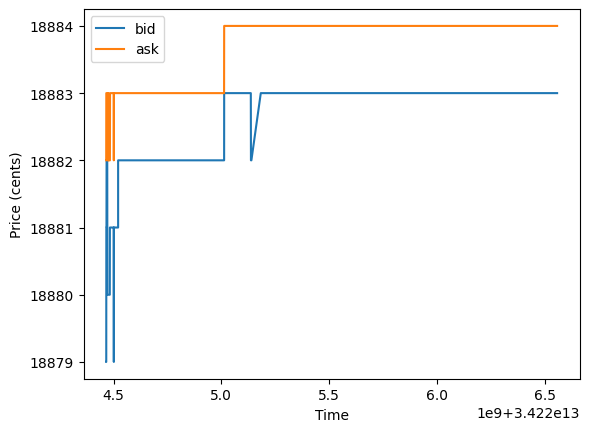

In [25]:
print("len(L1_gen):", len(L1_gen))

# plot L1_gen data
times = [L1_gen[i][0] for i in range(len(L1_gen))]
bids = [L1_gen[i][1][0] for i in range(len(L1_gen))]
asks = [L1_gen[i][2][0] for i in range(len(L1_gen))]
plt.plot(times, bids, label='bid')
plt.plot(times, asks, label='ask')

# # plot last 10000 time steps
# plt.plot(times[-10000:], bids[-10000:], label='bid')
# plt.plot(times[-10000:], asks[-10000:], label='ask')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

len(last_prices_gen): 89


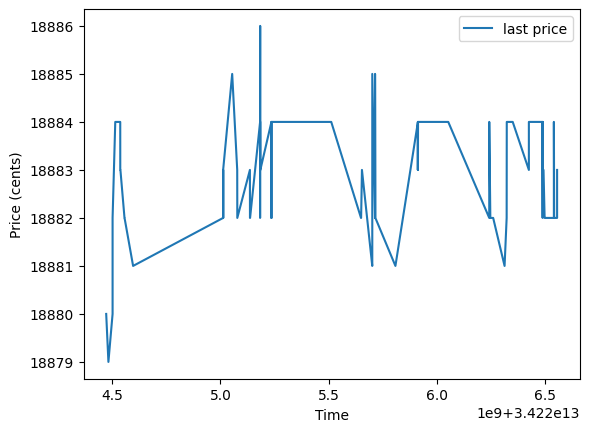

In [26]:
print("len(last_prices_gen):", len(last_prices_gen))

# plot last prices
times = [last_prices_gen[i][0] for i in range(len(last_prices_gen))]
prices = [last_prices_gen[i][1] for i in range(len(last_prices_gen))]
plt.plot(times, prices, label='last price')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Price (cents)")
plt.show()

# TODO: put in *-minute buckets plot series

Total number of messages: 4492
Add Order percentage: 50.98 %
Execute Order percentage: 1.98 %
Full Cancel Order percentage: 43.5 %
Partial Cancel Order percentage: 0.09 %
Replace Order percentage: 3.45 %


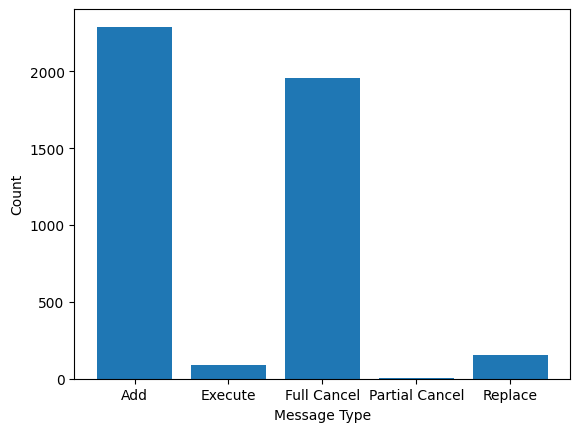

In [29]:
# print percentage of each message type
total_msgs = num_add_order_msgs + num_exec_order_msgs + num_full_cancel_order_msgs + num_partial_cancel_order_msgs + num_replace_order_msgs
print("Total number of messages:", total_msgs)
print("Add Order percentage:", round((num_add_order_msgs / total_msgs) * 100, 2), "%")
print("Execute Order percentage:", round((num_exec_order_msgs / total_msgs) * 100, 2), "%")
print("Full Cancel Order percentage:", round((num_full_cancel_order_msgs / total_msgs) * 100, 2), "%")
print("Partial Cancel Order percentage:", round((num_partial_cancel_order_msgs / total_msgs) * 100, 2), "%")
print("Replace Order percentage:", round((num_replace_order_msgs / total_msgs) * 100, 2), "%")

# plot message type counts
msg_types = ['Add', 'Execute', 'Full Cancel', 'Partial Cancel', 'Replace']
msg_counts = [num_add_order_msgs, num_exec_order_msgs, num_full_cancel_order_msgs, num_partial_cancel_order_msgs, num_replace_order_msgs]
plt.bar(msg_types, msg_counts)
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

In [27]:
nasdaq_agent.messages[-1]

(1,
 OrderCancelledMsg(message_id=19059, order=(Agent 1 @ 1970-01-01 09:30:25) : BID 100 AAPL @ $188.80))

In [35]:
vars(nasdaq_agent.messages[-2][1].order) #.time_placed #.order_id

{'agent_id': 1,
 'time_placed': 34224470830282,
 'symbol': 'AAPL',
 'quantity': 100,
 'side': <Side.BID: 'BID'>,
 'order_id': 54,
 'fill_price': 18880,
 'tag': None,
 'limit_price': 18880,
 'is_hidden': False,
 'is_price_to_comply': False,
 'insert_by_id': False,
 'is_post_only': False}

In [ ]:
# print("x.shape:", x.shape)
# print("x:", x)
# print("temperature:", temperature)
# print("top_k:", top_k)

# from torch.nn import functional as F

# idx = x

# for _ in range(max_new_tokens*encoded_tok_len):
#     with torch.no_grad():
#         # forward the model to get the logits for the index in the sequence
#         logits, _ = model(idx)
#         # pluck the logits at the final step and scale by desired temperature
#         logits = logits[:, -1, :] / temperature
#         # optionally crop the logits to only the top k options
#         if top_k is not None:
#             v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#             logits[logits < v[:, [-1]]] = -float('Inf')
#         # apply softmax to convert logits to (normalized) probabilities
#         probs = F.softmax(logits, dim=-1)
#         # sample from the distribution
#         idx_next = torch.multinomial(probs, num_samples=1)
#         # append sampled index to the running sequence and continue
#         idx = torch.cat((idx, idx_next), dim=1)

#         print("idx_next:", idx_next)

# print("last generated msg:", idx[0][-24:].tolist())

x.shape: torch.Size([1, 2448])
x: tensor([[12051,  1006, 12011,  ...,     2,     2,     2]], device='cuda:0')
temperature: 0.8
top_k: 200
idx_next: tensor([[12051]], device='cuda:0')
idx_next: tensor([[1003]], device='cuda:0')
idx_next: tensor([[12010]], device='cuda:0')
idx_next: tensor([[12008]], device='cuda:0')
idx_next: tensor([[11011]], device='cuda:0')
idx_next: tensor([[1018]], device='cuda:0')
idx_next: tensor([[2]], device='cuda:0')
idx_next: tensor([[3]], device='cuda:0')
idx_next: tensor([[3]], device='cuda:0')
idx_next: tensor([[3]], device='cuda:0')
idx_next: tensor([[982]], device='cuda:0')
idx_next: tensor([[37]], device='cuda:0')
idx_next: tensor([[227]], device='cuda:0')
idx_next: tensor([[468]], device='cuda:0')
idx_next: tensor([[1000]], device='cuda:0')
idx_next: tensor([[505]], device='cuda:0')
idx_next: tensor([[2]], device='cuda:0')
idx_next: tensor([[2]], device='cuda:0')
idx_next: tensor([[2]], device='cuda:0')
idx_next: tensor([[2]], device='cuda:0')
idx_next

In [ ]:
# @torch.no_grad()
# def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
#     """
#     Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
#     the sequence max_new_tokens times, feeding the predictions back into the model each time.
#     Most likely you'll want to make sure to be in model.eval() mode of operation for this.
#     """
#     for _ in range(max_new_tokens):
#         # if the sequence context is growing too long we must crop it at block_size
#         idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
#         # forward the model to get the logits for the index in the sequence
#         logits, _ = self(idx_cond)
#         # pluck the logits at the final step and scale by desired temperature
#         logits = logits[:, -1, :] / temperature
#         # optionally crop the logits to only the top k options
#         if top_k is not None:
#             v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
#             logits[logits < v[:, [-1]]] = -float('Inf')
#         # apply softmax to convert logits to (normalized) probabilities
#         probs = F.softmax(logits, dim=-1)
#         # sample from the distribution
#         idx_next = torch.multinomial(probs, num_samples=1)
#         # append sampled index to the running sequence and continue
#         idx = torch.cat((idx, idx_next), dim=1)

#     return idx

In [ ]:
# # Error correction: find matching order in order book or re-run timestep
# book = order_books[symbol].bids if direction.is_bid() else order_books[symbol].asks
# book

# for i, price_level in enumerate(book):
#     if not price_level.price == price:
#         continue

#     print("price match found at level:", i)
#     print("orders at this price level:", price_level.visible_orders)

#     # compile candidate orders
#     candidate_orders = []
#     for order in price_level.visible_orders:
#         print("order:", order[0])
#         candidate_orders.append(order[0]) if order[0].agent_id == WORLD_AGENT_ID else None

#     # find matching order
#     print("candidate orders:", candidate_orders)
#     candidiate_size_only = []
#     candidiate_time_only = []
#     for order in candidate_orders:
#         if order.quantity == fill_size and order.time_placed == ref_order_time:
#             print("matching order (size & time) found:", order)
#             # return deepcopy(order)
#         elif order.quantity == fill_size and order.time_placed != ref_order_time:
#             print("matching order (size only) found:", order)
#             candidiate_size_only.append(order)
#             # break
#         elif order.quantity != fill_size and order.time_placed == ref_order_time:
#             print("matching order (time only) found:", order)
#             candidiate_time_only.append(order)
#             # break
#         else:
#             print("no matching order found")
#             # break

#     if len(candidiate_size_only) >= 1:
#         print("return matching order (size only):", candidiate_size_only[0])
#         # return deepcopy(candidiate_size_only[0])
#     elif len(candidiate_time_only) >= 1:
#         print("return matching order (time only):", candidiate_time_only[0])
#         # return deepcopy(candidiate_time_only[0])
#     elif len(candidate_orders) >= 1:
#         print("no matching order found. Return initial volume at price level:", candidate_orders[0])
#         # return deepcopy(candidate_orders[0])

#     # return the fields needed to submit the order to the exchange
#     # based on event type, return order_id, ...

#     # return order_id, ...
# # throw error if no match found
# # raise ValueError("No matching order found in order book")


In [ ]:
# # INIT ORDER BOOKS FROM PROCESSED CONTEXT DATA

# # [ "ticker", "order_id", "event_type", "direction", "price_abs", "price",
# #  "fill_size", "remain_size", "delta_t_s", "delta_t_ns", "time_s", "time_ns",
# #  "old_id", "price_ref", "fill_size_ref", "time_s_ref", "time_ns_ref", "old_price_abs"]

# # init variables to keep track of previous time, price, etc.
# prev_time = first_message['time']
# prev_price = int(first_message['price']*100)

# # iterate through messages and update order books
# for msg in proc_messages:
#     # print(msg)
#     symbol = tickers[msg[0]]
#     # print("Symbol:", symbol)
#     order_id = msg[1]
#     # print("Order ID:", order_id)
#     event_type = msg[2]
#     # print("Event Type:", event_type)
#     price = msg[4]
#     # print("Price:", price)

#     # verify time correctness
#     assert prev_time + (msg[8]*1000000000) + msg[9] == (msg[10] * 1000000000) + msg[11]
#     time = prev_time + (msg[8]*1000000000) + msg[9]
#     # print("Time:", time)

#     # handle order based on event type
#     if event_type == 1:
#         # ADD LIMIT ORDER
#         direction = Side.BID if msg[3] == 0 else Side.ASK
#         # print("Direction:", direction)
#         fill_size = msg[6]
#         # print("Fill Size:", fill_size)
#         order = LimitOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=time,
#             symbol=symbol,
#             quantity=fill_size,
#             side=direction,
#             limit_price=price,
#         )
#         order_books[symbol].handle_limit_order(order)
#     elif event_type == 2:
#         # EXECUTE ORDER
#         fill_size = msg[6]
#         # print("Fill Size:", fill_size)
#         direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
#         # print("Direction:", direction)
#         order = MarketOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=time,
#             symbol=symbol,
#             quantity=fill_size,
#             side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
#         )
#         order_books[symbol].handle_market_order(order)
#     elif event_type == 3:
#         # EXECUTE ORDER WITH PRICE DIFFERENT THAN DISPLAY
#         # This order type is most likely an execution of a price-to-comply order, which is handled by the simulator
#         # but this not encoded in the ITCH data beforehand, so we cannot know whether an order is price-to-comply at the time of submission
#         # therefore, we handle this event type as a modifed order and then regular execution order (for now, until we revise the data processing)

#         # modfify the matched limit order
#         direction = Side.BID if msg[3] == 0 else Side.ASK
#         ref_order_time = (msg[15] * 1000000000) + msg[16]
#         ref_order_size = msg[14]
#         ref_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
#         # define original order
#         original_order = LimitOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=ref_order_time,
#             symbol=symbol,
#             quantity=ref_order_size,
#             side=direction,
#             limit_price=ref_order_price,
#         )
#         # define modified order
#         # modified_price = msg[4]
#         modified_order = LimitOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=ref_order_time,
#             symbol=symbol,
#             quantity=ref_order_size,
#             side=direction,
#             limit_price=price,
#         )
#         order_books[symbol].modify_order(original_order, modified_order)
#         # execute the modified order
#         fill_size = msg[6]
#         # print("Fill Size:", fill_size)
#         direction = Side.BID if msg[3] == 1 else Side.ASK # opposite of direction in non-execution messages
#         # print("Direction:", direction)
#         order = MarketOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=time,
#             symbol=symbol,
#             quantity=fill_size,
#             side=direction, # Buy Order if Side.BID (remove liquidity from ask side), Sell Order if Side.ASK (remove liquidity from bid side)
#         )
#         order_books[symbol].handle_market_order(order)
#     elif event_type == 4:
#         # CANCEL ORDER
#         direction = Side.BID if msg[3] == 0 else Side.ASK
#         # print("Direction:", direction)
#         ref_order_time = (msg[15] * 1000000000) + msg[16]
#         if msg[7] == 0:
#             # FULL DELETION
#             fill_size = msg[6]
#             # print("Cancel Size:", fill_size)
#             order = LimitOrder(
#                 order_id=order_id,
#                 agent_id=1, # world agent, leave alone for now
#                 time_placed=ref_order_time,
#                 symbol=symbol,
#                 quantity=fill_size,
#                 # quantity=msg[14], # total size of order when placed
#                 side=direction,
#                 limit_price=price,
#             )
#             order_books[symbol].cancel_order(order)
#         else:
#             # PARTIAL CANCELLATION
#             cancel_size = msg[6]
#             # print("Partial Cancel Size:", cancel_size)
#             ref_order_size = msg[7] + cancel_size # total size of order before partial cancel
#             order = LimitOrder(
#                 order_id=order_id,
#                 agent_id=1, # world agent, leave alone for now
#                 time_placed=ref_order_time,
#                 symbol=symbol,
#                 quantity=ref_order_size,
#                 side=direction,
#                 limit_price=price,
#             )
#             order_books[symbol].partial_cancel_order(order, cancel_size)
#     elif event_type == 5:
#         # REPLACE ORDER
#         direction = Side.BID if msg[3] == 0 else Side.ASK
#         # print("Direction:", direction)
#         old_order_id = msg[12]
#         old_order_time = (msg[15] * 1000000000) + msg[16]
#         old_order_size = msg[14]
#         old_order_price = msg[17] # old_price_abs (not mid_price so we cannot calculate using price_ref msg[13])
#         # define old order
#         old_order = LimitOrder(
#             order_id=old_order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=old_order_time,
#             symbol=symbol,
#             quantity=old_order_size,
#             side=direction,
#             limit_price=old_order_price,
#         )
#         new_order_size = msg[6]
#         # define new order
#         new_order = LimitOrder(
#             order_id=order_id,
#             agent_id=1, # world agent, leave alone for now
#             time_placed=time,
#             symbol=symbol,
#             quantity=new_order_size,
#             side=direction,
#             limit_price=price,
#         )
#         order_books[symbol].replace_order(1, old_order, new_order) # first arg is agent_id (world agent)
#     else:
#         raise NotImplementedError("Event type not implemented")

#     # update previous time and price
#     prev_time = time
#     prev_price = price

# # print end result
# print("L3 bid data:", order_books[symbols[0]].get_l3_bid_data())
# print("L3 ask data:", order_books[symbols[0]].get_l3_ask_data())
# nasdaq_agent.messages